In [56]:
import numpy as np
import pandas as pd
from collections import OrderedDict
import itertools
import statsmodels.formula.api as smf
import sys
import time
import requests
# Plotting packages
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics
from io import BytesIO
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
#electricity consumption data
waste_emissions = pd.read_csv('../../../data/tidy/solid-waste-emissions.csv') 

waste_emissions = waste_emissions.drop(columns=['Unnamed: 0'])  # Drop the first column
waste_emissions.set_index('Year', inplace=True)  # Set 'Year' column as index
waste_emissions

,New Haven waste emissions (MTCO2e),Hartford waste emissions (MTCO2e),Bridgeport waste emissions (MTCO2e)
Year,,,
2010,43626,571634,275685
2011,42748,454075,267775
2012,50998,454628,257262
2013,54846,442505,263672
2014,38632,439828,252879
2015,8283,414182,284651
2016,0,406323,287106
2017,0,416470,276424
2018,0,332352,264719


In [24]:
#split the test and trainig set
split_index = round(len(waste_emissions)*0.8)
df_train = waste_emissions.iloc[:split_index].copy()
df_test = waste_emissions.iloc[split_index:].copy()

<span style="font-family: verdana; color: green; font-size: 20px;font-weight: bold;">ARIMAX Model</span>

C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Val

0.03726266666666669 0.053336856800277735 13.085797351784887


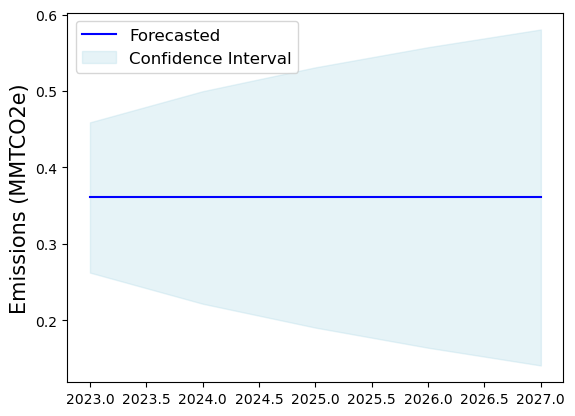

In [59]:
def sarima_forecast_metrics(train, test, forecast_horizon,plot_file):
    # Define the range of p, d, q parameters
    p = d = q = range(0, 3)

    # Generate all possible combinations of p, d, q parameters
    pdq = list(itertools.product(p, d, q))

    # Grid search for the optimal SARIMA parameters
    best_aic = float("inf")
    best_order = None
    for params in pdq:
        try:
            mod = sm.tsa.SARIMAX(train, order=params, seasonal_order=(0, 0, 0, 0))
            results = mod.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = params
        except:
            continue

    # Fit the SARIMA model with the optimal parameters
    mod = sm.tsa.SARIMAX(train, order=best_order, seasonal_order=(0, 0, 0, 0))
    res = mod.fit()

    test_forecast = res.get_prediction(start=len(HEM_train), end=len(HEM_train)+len(HEM_test)-1)
    test_forecast_mean = test_forecast.predicted_mean

    new_index = range(2023-len(HEM_test),2023)
    test_forecast_df = pd.DataFrame(list(test_forecast_mean.items()), columns=['Year', 'Emissions (MMTCO2e)'])
    test_forecast_df['Year'] = new_index

    # Set the 'Year' column as the index
    test_forecast_df.set_index('Year', inplace=True)

    actual_values = HEM_test
    predicted_values = test_forecast_df['Emissions (MMTCO2e)']

    mae = mean_absolute_error(actual_values, predicted_values)
    rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
    mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100

    forecast = res.forecast(steps=forecast_horizon)

    # Calculate the confidence interval
    forecast_object = res.get_forecast(steps=forecast_horizon)
    confidence_interval = forecast_object.conf_int()

    forecast.index = range(2023, 2023+forecast_horizon)
    plt.plot(forecast.index, forecast, color='blue', label='Forecasted')

    # Plot the confidence interval
    plt.fill_between(forecast.index, confidence_interval.iloc[:, 0], confidence_interval.iloc[:, 1], color='lightblue', alpha=0.3, label='Confidence Interval')

    plt.ylabel('Emissions (MMTCO2e)', fontsize=15)
    plt.legend(fontsize=12, loc='upper left')

    # Save the plot
    plt.savefig(plot_file)

    #plt.close()  # Close the plot to avoid displaying it again

    return mae, rmse, mape

HEM_train = df_train['Hartford waste emissions (MTCO2e)']/1000000
HEM_test = df_test['Hartford waste emissions (MTCO2e)']/1000000
plot_file = '../../../figures/hartford-forecast-emissions-solidwaste.png'  # File to save the plot

mae, rmse, mape = sarima_forecast_metrics(HEM_train, HEM_test,5, plot_file)
print(mae,rmse, mape)

In [57]:
def plot_arima(split_ratio,column_number):
    split_index = round(len(waste_emissions)*split_ratio)
    df_train = waste_emissions.iloc[:split_index].copy()
    df_test = waste_emissions.iloc[split_index:].copy()
    region_train = df_train.iloc[:, column_number]/1000000
    region_test = df_test.iloc[:, column_number]/1000000
    mod = pm.auto_arima(region_train, seasonal=False, trace=True)
    
    # Forecast on training data
    train_forecast = res.get_prediction(start=0, end=len(region_train)-1)
    train_forecast_mean = train_forecast.predicted_mean
    train_forecast_mean_re = train_forecast_mean
    train_conf_int = train_forecast.conf_int()

    new_index = [2020,2021,2022]

# Forecast on test data
    test_forecast = res.get_prediction(start=len(region_train), end=len(region_train)+len(region_test)-1)
    test_forecast_mean = test_forecast.predicted_mean
    test_conf_int = test_forecast.conf_int()
    test_conf_int.index = new_index

# Convert Series to DataFrame with the first column as the index
    test_forecast_df = pd.DataFrame(list(test_forecast_mean.items()), columns=['Year', 'New Haven-Milford (NHM)'])
    test_forecast_df['Year'] = new_index

    # Set the 'Year' column as the index
    test_forecast_df.set_index('Year', inplace=True)
    train_forecast_mean_re = train_forecast_mean
    
    actual_values = region_test
    # Extract the predicted values from the test forecast
    predicted_values = test_forecast_df['New Haven-Milford (NHM)']

    # Calculate MAE
    mae = mean_absolute_error(actual_values, predicted_values)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))

    # Calculate MAPE
    mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100
    
    # Plotting the results with confidence bands
    plt.figure(figsize=(12, 6))
    concatenated_observed = pd.concat([region_train,region_test])
    concatenated_predicted = pd.concat([train_forecast_mean_re, test_forecast_df['New Haven-Milford (NHM)']])
    concatenated_interval = pd.concat([train_conf_int, test_conf_int])

    #plot the observed value
    plt.plot(concatenated_observed.index, concatenated_observed, label='Observed', color='blue')

    #plot the predicted value
    plt.plot(concatenated_predicted.index, concatenated_predicted, label='Predicted', color='red', linestyle='--')

    # Plot confidence bands for training data
    plt.fill_between(concatenated_interval.index, concatenated_interval.iloc[:, 0], concatenated_interval.iloc[:, 1], color='orange', alpha=0.2)

    #combine the index
    combined_index = np.concatenate([region_train.index, test_forecast_df.index])

    plt.title('ARIMA Model Forecast with Confidence Intervals', fontsize=18)
    # Adjust x-axis ticks and labels
    plt.xticks(combined_index, rotation=45)

    #plt.xlabel('Time', fontsize=16)
    plt.ylabel('Solid Waste GHG Emissions (MMTCO2e)', fontsize=15)
    plt.legend(fontsize=16)

    # Set x-axis and y-axis tick labels with fontsize
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)


    plt.savefig('../../../figures/arimax-solidwaste-emissions-Hartford.png', dpi=600, bbox_inches='tight')

    # Show the plot
    plt.show()
    

NameError: name 'pm' is not defined